# Solving portfolio optimization as QUBO problem with QAOA

## Overview

Here we show how to solve a quadratic unconstrained binary optimization (QUBO) problem using QAOA.  Later on below we will extend this to show how to solve binary Markowitz portfolio optimization problems.

## QUBO problem

### what is QUBO?

Quadratic unconstrained binary optimization (QUBO) is a type of problem that aims to optimize a quadratic objective function using binary variables. In a QUBO problem, the objective is to find the binary variable assignments that minimize or maximize the quadratic objective function. These variables represent choices or decision variables that can be either selected (1) or not selected (0). The objective function reflects the associated costs, benefits, or constraints linked to these decisions.

QUBO is a NP-hard problem.

### An example

We illustrate the QUBO problem with a simple example. Consider minimizing the following 2x2 QUBO objective function:

$\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2$

Clearly this is minimized at $(x_1,x_2) = (1,0)$, with corresponding objective function value of $-5$

We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 $$

which simplifies to

$$-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 

$$\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle$$ 

Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$)

## Setup

In [4]:
import tensorcircuit as tc
from tensorcircuit.applications.vags import cvar
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time
import scipy.optimize as optimize

No module named 'cirq'
Therefore some functionality in tensorcircuit.applications.layers may not work
name 'cirq' is not defined
cirq layer generation disabled
No module named 'cirq'
Therefore some functionality in tensorcircuit.applications.vags may not work
name 'sympy' is not defined
tfq related vags disabled due to missing packages


In [5]:
K = tc.set_backend("tensorflow")

nlayers = 2
states = []
for i in range(4):
    states.append(f"{bin(i)[2:]:0>{2}}")

# see below for a function to generate the pauli terms and weights from the QUBO matrix

### Convert the Q-matrix to Ising Hamiltonian

In [6]:
def QUBO_to_Ising(Q):
    # input is n-by-n symmetric numpy array corresponding to Q-matrix
    # output is the components of Ising Hamiltonian

    n = Q.shape[0]

    offset = np.triu(Q, 0).sum() / 2
    pauli_terms = []
    weights = -np.sum(Q, axis=1) / 2

    for i in range(n):
        term = np.zeros(n)
        term[i] = 1
        pauli_terms.append(term)

    for i in range(n - 1):
        for j in range(i + 1, n):
            term = np.zeros(n)
            term[i] = 1
            term[j] = 1
            pauli_terms.append(term)

            weight = Q[i][j] / 2
            weights = np.concatenate((weights, weight), axis=None)

    return pauli_terms, weights, offset


In [7]:
Q = np.array([[-5, -2], [-2, 6]])
pauli_terms, weights, offset = QUBO_to_Ising(Q)
print("The pauli terms in this QUBO problem are: ", pauli_terms)
print("and correspond weights are:", weights)
print("the offset is:", offset)

The pauli terms in this QUBO problem are:  [array([1., 0.]), array([0., 1.]), array([1., 1.])]
and correspond weights are: [ 3.5 -2.  -1. ]
the offset is: -0.5


The results are consistent with our analysis.

### Ansatz

In [8]:
# Now we define the QAOA ansatz of depth nlayers
def QAOA_from_Ising(params, nlayers, pauli_terms, weights):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        for i in range(nqubits):
            c.rx(i, theta=params[2 * j + 1])  # mixing terms
    return c


### Loss function

For a general state that is the output of a quantum circuit c, we first define the corresponding loss with respect to the Ising Hamiltonian.

In [9]:
def Ising_loss(c, pauli_terms, weights):
    loss = 0.0
    for k in range(len(pauli_terms)):
        term = pauli_terms[k]
        index_of_ones = []

        for l in range(len(term)):
            if term[l] == 1:
                index_of_ones.append(l)

        if len(index_of_ones) == 1:
            delta_loss = weights[k] * c.expectation_ps(z=[index_of_ones[0]])

        else:
            delta_loss = weights[k] * c.expectation_ps(
                z=[index_of_ones[0], index_of_ones[1]]
            )

        loss += delta_loss

    return K.real(loss)


In [10]:
def Ising_loss_Q(c, Q):
    n_qubits = c._nqubits
    prob = c.probability()
    loss = 0.0
    for i in range(len(prob)):
        state = f"{bin(i)[2:]:0>{n_qubits}}"
        x = np.array([int(bit) for bit in state])
        loss += np.dot(x, np.dot(Q, x)) * prob[i]
        print(loss)
    return K.real(loss)

For the particular case of a circuit corresponding to a QAOA ansatz this is:

In [11]:
def QAOA_loss(nlayers, pauli_terms, weights, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss(c, pauli_terms, weights)


In [12]:
def QAOA_loss_Q(nlayers, pauli_terms, weights, Q, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss_Q(c, Q)


In [13]:
def QUBO_QAOA(Q, ansatz, nlayers, iterations):
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(ansatz, nlayers, pauli_terms, weights))
    loss_val_grad_jit = K.jit(loss_val_grad)

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))

    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    params = tf.cast(params, tf.float32)
    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        params = opt.update(grads, params)

    return params

### Results

In [14]:
iterations = 5#00
time_start = time.time()
final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 5.5602 s


In [15]:
c = QAOA_from_Ising(final_params, nlayers, pauli_terms, weights)
probs = K.numpy(c.probability()).round(decimals=4)
# prob_dict = {states[i]: probs[i] for i in range(4)}
# prob_sorted = dict(sorted(prob_dict.items(), key=lambda item: item[1], reverse=True))
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")


-------------------------------------
    selection	  |	probability
-------------------------------------
        10	  |	  0.2783
        11	  |	  0.2734
        00	  |	  0.2523
        01	  |	  0.1959
-------------------------------------


We note that for nlayers=2 and 500 iterations, the objective function does not in this case (although it depends on the initial parameters) converge to the true value of $-4.5$.  However, the we see below that the final wavefunction does have large overlap with the desired state $|10\rangle$, so measuring the output of the QAOA algorithm will, with high probability, output the correct answer.

In [16]:
def print_output(c):
    n = c._nqubits
    N = 2**n
    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]
    plt.bar(range(N), c.probability())
    plt.xticks(range(N), labels, rotation=70)

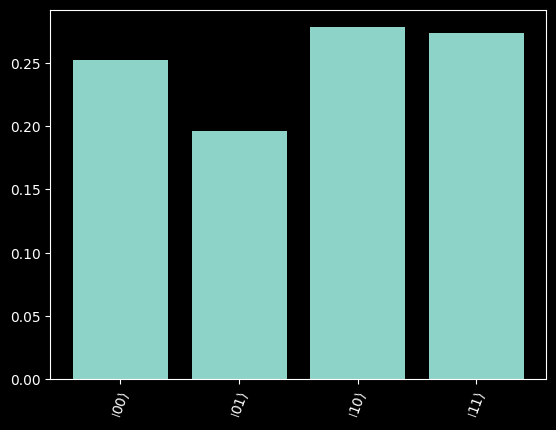

In [17]:
print_output(c)


## General Case

For the general QUBO case, we wish to minimize

$$ x^T Q x$$

where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This maps to an Ising Hamiltonian 

$$\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j$$

Below is a simple function which can perform this mapping:

## Portfolio problem

Consider a scenario: Xiaoming, a wise individual, has an amount of money denoted as $B$, and he intends to invest it in the stock market. The market consists of $n$ shares from which he can choose (assuming all shares have the same price). Naturally, Xiaoming aims to maximize returns while minimizing risk. Additionally, it's important to note that individuals have varying levels of risk tolerance. Xiaoming's risk tolerance is denoted as $p$. Given these factors, which shares should Xiaoming select to construct his portfolio?



### Solving portfolio optimization problems with QAOA

In a simple boolean Markowitz portfolio optimization problem, we wish to solve 

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^T x$$

subject to 

$$ 1^T x = B$$

where 
* $n$: number of assets under consideration
* $q > 0 $: risk-appetite
* $\Sigma \in \mathbb{R}^{n\times n}$: covariance matrix of the assets
* $\mu\in\mathbb{R}^n$: mean return of the assets
* $B$: budget (i.e., total number of assets out of $n$ that can be selected)

Our first step is to convert this constrained quadratic programming problem into a QUBO.  We do this by adding a penalty factor $t$ and consider the alternative problem:

$$ \min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^Tx  + t(1^Tx-B)^2$$

The variables in the linear terms $\mu^Tx = \mu_1 x_1 + \mu_2 x_2+\ldots$ can all be squared (since they are boolean variables), i.e. we can consider

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \sum_{i=1}^n\mu_i x_i^2  + t(1^Tx-B)^2$$

which is a QUBO defined by the matrix $Q$ 

$$ Q = q\Sigma -\mu\begin{pmatrix}1 & \\ & 1\\ & & \ddots\end{pmatrix} + t\begin{pmatrix}1 -2B & 1 & \ldots & 1 \\
1 & 1-2B & 1 & \ldots \\1 & 1 & 1-2B \\
\vdots\end{pmatrix}$$

i.e., we wish to mimimize

$$ x^T Q X + tB^2$$

and we ignore the constant term $t B^2$.
We can now solve this by QAOA as above.

Let us first define a function to convert portfolio data into a QUBO matrix:

In [18]:
import datetime
from qiskit_finance.data_providers import RandomDataProvider
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
print(mu)
print(sigma)

[ 0.01528439 -0.00078095  0.00051792  0.00087001]
[[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04]]


In [19]:
class StockData:
    """convert real-world stock data to annualized covariance matrix, annualized return and penalty factor
    input: a list of continuous stock data in the same time span (risk preference & budget for penalty factor)
    output: annualized convariance matrix and return
    """

    def __init__(self, data):
        self.data = data  # add data
        self.n_stocks = len(data)  # num of stocks

        # check the number of days
        n_days = [len(i) for i in data]
        if max(n_days) != (sum(n_days) / len(n_days)):
            raise Exception("timespan of stocks should be the same")
        self.n_days = len(data[1])

        # calculate the daily percentage price change
        self.daily_change = []  # daily percentage price change
        for i in range(self.n_stocks):
            each_stcok = []
            for j in range(self.n_days - 1):
                each_stcok.append((data[i][j + 1] - data[i][j]) / data[i][j])
            self.daily_change.append(each_stcok)

    # calculate annualized return (mu)
    def get_return(self):
        change = [[i + 1 for i in j] for j in self.daily_change]  # daily_change + 1
        ret = [np.prod(i) ** (252 / self.n_days) for i in change]
        return ret

    # calculate annualized covariance matrix (sigma)
    def get_covariance(self):
        mean_change = [
            [i - np.mean(j) for i in j] for j in self.data
        ]  # daily_change - mean(daily_change)
        cov = 252 / self.n_days * np.dot(mean_change, np.transpose(mean_change))
        return cov

    def get_penalty(self, cov, ret, risk_pre, budget):
        # get all fesible and unfeasible states
        self.f_state = []  # feasible states (num of '1's equal to budge)
        self.uf_state = []  # unfeasible states
        self.all_state = []
        for i in range(2**self.n_stocks):
            state = f"{bin(i)[2:]:0>{self.n_stocks}}"
            n_ones = 0
            for j in state:
                if j == "1":
                    n_ones += 1
            self.all_state.append(state)
            if n_ones == budget:
                self.f_state.append(state)
            else:
                self.uf_state.append(state)

        # determine the penalty factor
        # follow this paper: https://doi.org/10.1007/s11128-022-03766-5 
        mark = False
        penalty = 0  # initial value
        while mark == False:
            R = np.diag(ret)
            S = np.ones((self.n_stocks, self.n_stocks)) - 2 * budget * np.diag(
                np.ones(self.n_stocks)
            )
            Q = risk_pre * cov - R + penalty * S
            F = []
            for state in self.f_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty*budget**2)
            Fmin = np.amin(F)
            Fbar = np.mean(F)
            F = []
            for state in self.uf_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty*budget**2)
            Fmin_uf = np.amin(F)
            location = np.where(F == Fmin_uf)[0][0]
            if Fmin_uf < 0.5 * (Fmin + Fbar):
                n_ones = 0
                for j in self.uf_state[location]:
                    if j == "1":
                        n_ones += 1
                penalty += (0.5 * (Fmin + Fbar) - Fmin_uf) / (n_ones - budget) ** 2
            else:
                mark = True  # ready to return the penalty
        return penalty

In [20]:
a = [1, 2, 3]
p = np.max(a)
np.nonzero(a == p)[0][0]

2

In [21]:
# real-world stock data, calculated using the functions above
# stock name: aapl, amzn, meta, msft, qcom, sbux
# from 10/06/2022 to 09/06/2023
mu = [
    0.4571994114695688,
    0.41041212627281065,
    1.1642126120700402,
    1.9833591772807886,
    1.7411375568887029,
    0.7113494810370135,
]
sigma = np.array(
    [
        [
            44153.50197136,
            16427.86899847,
            17925.90406014,
            12591.01917775,
            5243.16167421,
            1734.98958898,
        ],
        [
            16427.86899847,
            30484.04551246,
            31296.89782714,
            16693.96263967,
            17870.1769762,
            381.2127035,
        ],
        [
            17925.90406014,
            31296.89782714,
            168080.73099969,
            31466.58363902,
            39030.04232952,
            754.80389469,
        ],
        [
            12591.01917775,
            16693.96263967,
            31466.58363902,
            119234.81518309,
            43426.60861475,
            -388.64584922,
        ],
        [
            5243.16167421,
            17870.1769762,
            39030.04232952,
            43426.60861475,
            35809.54588731,
            -791.57350614,
        ],
        [
            1734.98958898,
            381.2127035,
            754.80389469,
            -388.64584922,
            -791.57350614,
            1970.16654172,
        ],
    ]
)

In [22]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    """convert portfolio parameters to a Q-matrix
    cov: n-by-n covariance numpy array
    mean: numpy array of means
    q: the risk preference of investor
    B: budget
    t: penalty factor
    """
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

We can test this using the qiskit_finance package to generate some stock covariance and mean data:

*Note that this was tested with qiskit version 0.39.3 and qiskit-finance version 0.3.4.*

Using this mean and covariance data, we can now define our portfolio optimization problem, convert it to a QUBO matrix, and then extract the pauli terms and weights

In [23]:
q = 0.5 # the risk preference of investor
budget = 3  # Note that in this example, there are 6 assets, but a budget of only 3
penalty = 80299.22578764349 # calculated using the function above

#Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)

In [24]:
Fbar = 146662.570242461
Fmin = 47150.2753
0.5*(Fbar+Fmin)

96906.4227712305

In [25]:
states = []
for i in range(2**6):
    a = f"{bin(i)[2:]:0>{6}}"
    n_ones = 0
    for j in a:
        if j == '1':
            n_ones += 1
    if True:#n_ones != budget:
        states.append(a)
print(states)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


In [26]:
# Brutely search over classical results for comparison before we run QAOA
# the results are sorted with cost
cost_dict = {}
i = 0
for selection in states:
    x = np.array([int(bit) for bit in selection])
    cost_dict[selection] = np.dot(x, np.dot(Q, x))
    i += 1
cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
print("\n-------------------------------------")
print("    selection\t  |\t  cost")
print("-------------------------------------")
for k, v in cost_sorted.items():
    print("%10s\t  |\t%.4f" % (k, v))
print("-------------------------------------")


-------------------------------------
    selection	  |	  cost
-------------------------------------
    100011	  |	-675542.7568
    010011	  |	-671104.1998
    110001	  |	-665846.6827
    010101	  |	-630165.0941
    110010	  |	-627930.8865
    100101	  |	-626079.5792
    010001	  |	-625786.6093
    000011	  |	-624297.9761
    100001	  |	-617598.1510
    000111	  |	-601943.8149
    100010	  |	-597171.3190
    101001	  |	-595177.4676
    010010	  |	-591378.9852
    011001	  |	-589994.9321
    110000	  |	-588648.0312
    000101	  |	-582182.6560
    001011	  |	-580773.1544
    110100	  |	-580046.8509
    100110	  |	-561837.4928
    001001	  |	-556615.4292
    010110	  |	-551942.2155
    010100	  |	-550842.8071
    100100	  |	-548111.0691
    001101	  |	-546221.2930
    110011	  |	-545322.6600
    101010	  |	-536475.3971
    111000	  |	-535685.2538
    000110	  |	-521448.7416
    101000	  |	-518352.4072
    011010	  |	-517312.0695
    011000	  |	-511816.0948
    001010	  |	-501421.5309
  

We see that, due to the penalty, the lowest energy solutions correspond to 0111, 1011, 1101, 1110, i.e. the portfolios with only 3 assets.

In [27]:
iterations = 1#000
nlayers = 10
time_start = time.time()
final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 32.5925 s


In [28]:
c_final = QAOA_from_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)
states = []
for i in range(2**6):
    a = f"{bin(i)[2:]:0>{6}}"
    states.append(a)
probs = K.numpy(c_final.probability()).round(decimals=6)
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")



-------------------------------------
    selection	  |	probability
-------------------------------------
    101110	  |	  0.0859
    100111	  |	  0.0625
    100011	  |	  0.0481
    111011	  |	  0.0439
    110011	  |	  0.0367
    011011	  |	  0.0358
    010100	  |	  0.0357
    110110	  |	  0.0356
    110001	  |	  0.0350
    100010	  |	  0.0348
    011101	  |	  0.0297
    000000	  |	  0.0278
    101001	  |	  0.0220
    011000	  |	  0.0219
    001000	  |	  0.0213
    010011	  |	  0.0209
    010110	  |	  0.0187
    010000	  |	  0.0185
    110100	  |	  0.0184
    101111	  |	  0.0180
    111101	  |	  0.0176
    000010	  |	  0.0171
    011100	  |	  0.0170
    100100	  |	  0.0167
    001010	  |	  0.0150
    010111	  |	  0.0147
    100000	  |	  0.0141
    001110	  |	  0.0139
    111000	  |	  0.0134
    000101	  |	  0.0127
    000001	  |	  0.0122
    000011	  |	  0.0121
    010001	  |	  0.0114
    001011	  |	  0.0104
    100001	  |	  0.0100
    011111	  |	  0.0093
    001100	  |	  0.0092
    1

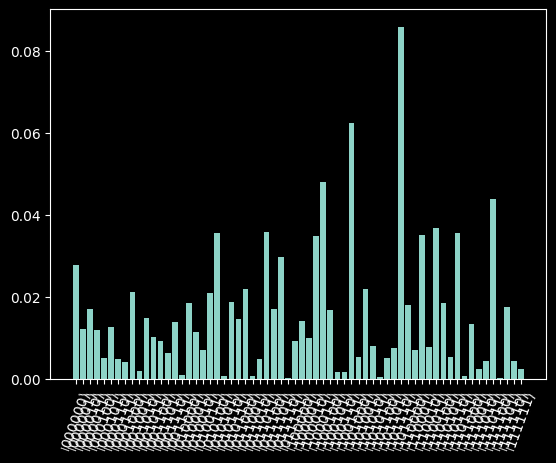

In [29]:
print_output(c_final)


### Influence of different mixers

In [30]:
# difine an universal QAOA ansatz
def QAOA_ansatz(params, nlayers, pauli_terms, weights, mixer="standard"):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        # standard mixer term
        if mixer == "normal":
            for i in range(nqubits):
                c.rx(i, theta=params[2 * j + 1])

        # ring mixer
        if mixer == "ring":
            for i in range(nqubits - 1):
                c.exp1(
                    index_of_ones[i],
                    index_of_ones[i + 1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1],
                )
            c.exp1(
                index_of_ones[-1],
                index_of_ones[0],
                unitary=tc.gates._xx_matrix,
                theta=params[2 * j + 1],
            )

        # parity ring mixer
        if mixer == "par_ring":
            half = int(nqubits / 2)
            for i in range(half + 1):  # even
                c.exp1(
                    index_of_ones[2 * i - 1],
                    index_of_ones[2 * i],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1],
                )
            for i in range(half - 1):  # odd
                c.exp1(
                    index_of_ones[2 * i],
                    index_of_ones[2 * i + 1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1 + half],
                )
            if 2 * half < nqubits:
                c.exp1(
                    index_of_ones[2 * half],
                    index_of_ones[2 * half + 1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1 + half],
                )

        # full mixer
        if mixer == "full":
            pass
        #
        if mixer == "QAMPA":
            pass
    return c

### Use CVaR

In [31]:
def cvar_value(r, p, percent):
    rs = sorted(
        [(i, j) for i, j in enumerate(r)], key=lambda s: -s[1]
    )  # larger to smaller
    sump = 0.0  # the sum of probability
    count = 0
    cvar_result = 0.0
    while sump < percent:
        if round(sump + p[rs[count][0]], 7) >= percent:
            cvar_result += rs[count][1] * (percent - sump)
            count += 1
            break
        else:
            sump += p[rs[count][0]]
            cvar_result += rs[count][1] * p[rs[count][0]]
            count += 1

    cvar_result /= percent
    return K.real(cvar_result)

In [32]:
def cvar_from_circuit(circuit, num_samples, Q, alpha):
    s = circuit.state()
    results = tc.quantum.measurement_results(
        s, counts=num_samples, format="count_dict_bin"
    )  # get readouts
    results = {k: v / num_samples for k, v in results.items()}
    values = []  # passed to cvar
    probability = []  # passed to cvar
    for k, v in results.items():
        x = np.array([int(bit) for bit in k])
        values.append(np.dot(x, np.dot(Q, x)))
        probability.append(v)
    cvar_result = cvar_value(values, probability, alpha)
    return cvar_result

In [33]:
cvar_result = cvar_from_circuit(c_final, 1000, Q, 1)
print(cvar_result)


tf.Tensor(-452574.0296917448, shape=(), dtype=float64)


In [34]:
def cvar_loss(nlayers, Q, pauli_terms, weights, percent, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return cvar_from_circuit(c, 1000, Q, percent)


In [37]:
def QUBO_CVaR(Q, nlayers, alpha):
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss = partial(cvar_loss, nlayers, Q, pauli_terms, weights, alpha)
    # value, COBYLA
    
    f_scipy = tc.interfaces.scipy_interface(loss, shape=[2 * nlayers], jit=False, gradient=False)
    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    r = optimize.minimize(f_scipy, params, method="COBYLA")

    return r

In [45]:
#iterations = 500
time_start = time.time()
final_params = QUBO_CVaR(Q, nlayers, 0.1)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 138.1176 s


In [44]:
final_params.x
c_final = QAOA_from_Ising(
    final_params.x, nlayers, portfolio_pauli_terms, portfolio_weights
)
states = []
for i in range(2**6):
    a = f"{bin(i)[2:]:0>{6}}"
    states.append(a)
probs = K.numpy(c_final.probability()).round(decimals=6)
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")


-------------------------------------
    selection	  |	probability
-------------------------------------
    100000	  |	  0.0930
    101010	  |	  0.0652
    001111	  |	  0.0599
    110100	  |	  0.0535
    001000	  |	  0.0485
    100011	  |	  0.0441
    011100	  |	  0.0398
    000101	  |	  0.0344
    011000	  |	  0.0336
    010000	  |	  0.0318
    011011	  |	  0.0286
    101011	  |	  0.0271
    001110	  |	  0.0227
    000110	  |	  0.0209
    011101	  |	  0.0205
    001100	  |	  0.0204
    011010	  |	  0.0198
    001101	  |	  0.0190
    100101	  |	  0.0188
    010110	  |	  0.0186
    101110	  |	  0.0160
    100010	  |	  0.0148
    000000	  |	  0.0139
    101001	  |	  0.0136
    010011	  |	  0.0124
    000010	  |	  0.0114
    110101	  |	  0.0112
    110011	  |	  0.0111
    000011	  |	  0.0107
    000111	  |	  0.0106
    111101	  |	  0.0098
    011110	  |	  0.0095
    010111	  |	  0.0092
    111111	  |	  0.0083
    111100	  |	  0.0079
    110000	  |	  0.0079
    010101	  |	  0.0078
    0